## Strategy Development Module

In [1]:
import pandas as pd
import numpy as np
import logging
import random as rnd
import operator

from typing import Any, Callable, List, Tuple, Dict, Union, Optional
from typeguard import typechecked
from functools import partial
from abc import ABC, abstractmethod
from queue import Queue, Empty
from itertools import product
from collections.abc import Iterable, Iterator

from constants import *
#from event import MarketEvent

In [2]:
logging.basicConfig(level=logging.DEBUG,
                    format='[%(asctime)s %(levelname)-8s line %(lineno)s] %(funcName)30s: %(message)s',
                    datefmt='%a, %d %b %Y %H:%M:%S')

-----
### Loading data for examples

In [3]:
from data import DataHandler, CSVDataHandler
from visual import StockTradingGraph

[Sat, 14 Mar 2020 14:09:24 DEBUG    line 225]                 switch_backend: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
[Sat, 14 Mar 2020 14:09:24 DEBUG    line 225]                 switch_backend: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [4]:
bars = CSVDataHandler('data', TIMEFRAME_DAY,
                      {'IMOEX':
                       {'src': 'finam', 'tz': 'Europe/Moscow'}
                      })
symbol = 'IMOEX'
df = bars.all_bars(symbol)

[Sat, 14 Mar 2020 14:09:25 DEBUG    line 171]                 _convert_files: No exact name is given. Take all files IMOEX<...>.csv
[Sat, 14 Mar 2020 14:09:25 DEBUG    line 180]                 _convert_files: No time column is given


In [5]:
df.head()

,open,high,low,close,volume
datetime,,,,,
2000-01-05,173.00,173.00,173.00,173.00,0.0
2000-01-06,186.26,186.26,186.26,186.26,0.0
2000-01-10,200.81,200.81,200.81,200.81,0.0
2000-01-11,199.57,199.57,199.57,199.57,0.0
2000-01-12,196.88,196.88,196.88,196.88,0.0


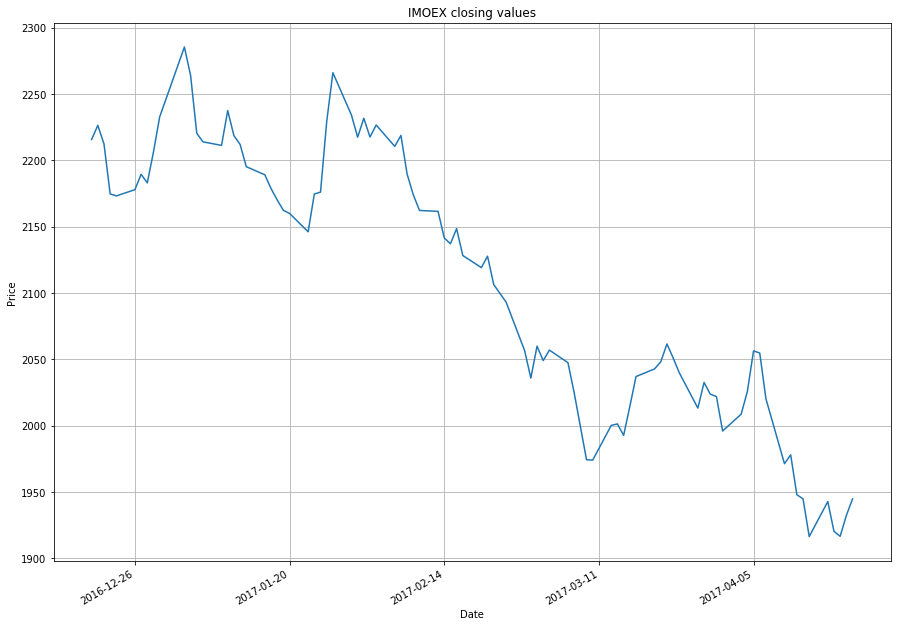

In [6]:
visualizer = StockTradingGraph()
visualizer.show_property(df.close, from_date='2016-12-19', to_date='2017-04-21', title='IMOEX closing values')

-----
### Classes for Strategy definition

In [6]:
@typechecked
class Indicator:
    """
    Class with Indicators definitions.
    
    By Indicator we understand ANY function, 
    applied to a Series and returning Series as a result.
    Shoul satisfy tpIndicator = Callable[[tpSeries], tpSeries]
    
    TODO: Import standard financial libraries.
    """
    
    @staticmethod
    def sma(prices: tpSeries, **kwargs) -> tpSeries:
        """
        Simple Moving Average. 
        
        Expects 'window' in parameters dictionary - 
        number of previous bars for calucating average.
        
        Parameters:
        prices - Series of prices for function application
        
        Returns:
        Series of resulting calculations
        """
    
        if 'window' not in kwargs:
            raise KeyError('Parameters list must contain a window value')
        return prices.rolling(kwargs['window']).mean().fillna(0)    

Example call:

In [7]:
sma_close_5 = Indicator.sma(df.close, window = 5)
sma_close_5.head(10)

datetime
2000-01-05      0.000
2000-01-06      0.000
2000-01-10      0.000
2000-01-11      0.000
2000-01-12    191.304
2000-01-13    198.714
2000-01-14    204.918
2000-01-17    208.702
2000-01-18    211.364
2000-01-19    212.120
Name: close, dtype: float64

Example of __partial__ call:

In [8]:
indicator = partial(Indicator.sma, window = 5)
indicator(df.close).head(10)

datetime
2000-01-05      0.000
2000-01-06      0.000
2000-01-10      0.000
2000-01-11      0.000
2000-01-12    191.304
2000-01-13    198.714
2000-01-14    204.918
2000-01-17    208.702
2000-01-18    211.364
2000-01-19    212.120
Name: close, dtype: float64

In [9]:
@typechecked
class Policy:
    """
    Class defines different policies of applying the Indicator.
    """
    
    @classmethod
    def cross(cls, fst:tpSeries, snd:tpSeries, 
              ret_val:int = 1, op = operator.eq) -> tpSeries:
        """
        Generate Series, where ret_val is where fst Series cross snd Series, 
        otherwise NaN 
        
        Parameters:
        fst - first Series of Data
        snd - second Series of Data
        ret_val - value to be returned
        op - operator for comparison, equal by default
        
        Returns:
        Series with ret_val and NaN
        """
        
        sign = np.sign(fst - snd)
        change = op(sign, sign.shift())
        return ret_val * change.where(change)
    
    @classmethod
    def up_cross_indicator(cls, prices: tpSeries, indicator: tpIndicator, 
                           ret_val:int, **kwargs) -> tpSeries:
        """
        Generate Series, where ret_val is where prices up cross indicator, 
        otherwise NaN 
        
        Parameters:
        prices - Series of Data
        indicator - indicator, applied to the prices
        ret_val - value to be returned
        
        Returns:
        Series with ret_val and NaN
        """
        return cls.cross(prices, indicator(prices, **kwargs), ret_val, operator.lt)
    
    @classmethod
    def down_cross_indicator(cls, prices: tpSeries, indicator: tpIndicator, 
                             ret_val:int, **kwargs) -> tpSeries:
        """
        Generate Series, where ret_val is where prices down cross indicator, 
        otherwise NaN 
        
        Parameters:
        prices - Series of Data
        indicator - indicator, applied to the prices
        ret_val - value to be returned
        
        Returns:
        Series with ret_val and NaN
        """
        return cls.cross(prices, indicator(prices, **kwargs), ret_val, operator.gt)
    
    @classmethod
    def propagate(cls, signal: tpSeries, ret_val: int, **kwargs) -> tpFrame:
        """
        Propagate signal for several bars. 
        Number of bars is a 'window' parameter in kwargs.
        ------------------
        | index | signal |
        |-------|--------|
        |   0   |   1    |
        |   1   |  NaN   |
        |   2   |  NaN   |
        |   3   |  NaN   |
        ------------------
        ret_val = 0, window = 2
        ---------------------------
        | index | signal | sindex |
        |-------|--------|--------|
        |   0   |   NaN  |   NaT  |
        |   1   |   NaN  |   NaT  |
        |   2   |    0   |    0   |
        |   3   |   NaN  |    1   |
        ---------------------------
        
        Parameters:
        signal - Series of original signal
        ret_val - value for returning
        
        Returns:
        DataFrame[signal, sindex] - shifted signal and index to what it belongs
        """
        
        if 'window' not in kwargs:
            raise KeyError('Parameters list must contain window value')   
        w = kwargs['window']
        if w < 0:
            raise ValueError('Value of window must be >= 0')   

        # buy-and-hold strategy
        if w == 0:
            # returns only NaN == never exit
            return signal.mask(abs(signal) == 1, np.NaN)
        else: # w > 0
            result = pd.DataFrame()
            result['signal'] = signal.copy()
            result['signal'] = result.signal.mask(abs(result.signal) == 1, ret_val)
            result['sindex'] = signal.index
            result = result.shift(w)
            return result

Example calls:

In [10]:
enter_longs = Policy.down_cross_indicator(df.close, Indicator.sma, SIGNAL_LONG,  window = 30)
enter_longs[320:335] #[29:45]

datetime
2001-04-16    NaN
2001-04-17    NaN
2001-04-18    1.0
2001-04-19    NaN
2001-04-20    NaN
2001-04-23    NaN
2001-04-24    1.0
2001-04-25    NaN
2001-04-26    NaN
2001-04-27    NaN
2001-04-28    NaN
2001-05-03    NaN
2001-05-04    NaN
2001-05-07    NaN
2001-05-08    NaN
Name: close, dtype: float64

In [13]:
exit_longs = Policy.propagate(enter_longs, SIGNAL_EXIT, window = 4)
exit_longs[320:335] #[29:45]

,signal,sindex
datetime,,
2001-04-16,0.0,2001-04-10
2001-04-17,NaN,2001-04-11
2001-04-18,NaN,2001-04-12
2001-04-19,NaN,2001-04-13
2001-04-20,NaN,2001-04-16
2001-04-23,NaN,2001-04-17
2001-04-24,0.0,2001-04-18
2001-04-25,NaN,2001-04-19
2001-04-26,NaN,2001-04-20


Example calls with __partial__ applying of indicator:

In [11]:
indicator = partial(Indicator.sma, window = 30)
enter_shorts = Policy.up_cross_indicator(df.close, indicator, SIGNAL_SHORT)
enter_shorts[320:335] #[29:45]

datetime
2001-04-16    NaN
2001-04-17   -1.0
2001-04-18    NaN
2001-04-19    NaN
2001-04-20    NaN
2001-04-23   -1.0
2001-04-24    NaN
2001-04-25    NaN
2001-04-26    NaN
2001-04-27    NaN
2001-04-28    NaN
2001-05-03    NaN
2001-05-04    NaN
2001-05-07    NaN
2001-05-08    NaN
Name: close, dtype: float64

In [12]:
exit_shorts = partial(Policy.propagate, ret_val = SIGNAL_EXIT, window = 4)
exit_shorts(signal = enter_shorts)[320:335] #[29:45]

,signal,sindex
datetime,,
2001-04-16,NaN,2001-04-10
2001-04-17,NaN,2001-04-11
2001-04-18,NaN,2001-04-12
2001-04-19,NaN,2001-04-13
2001-04-20,NaN,2001-04-16
2001-04-23,0.0,2001-04-17
2001-04-24,NaN,2001-04-18
2001-04-25,NaN,2001-04-19
2001-04-26,NaN,2001-04-20


------
### StrategyFrame and Strategy Classes

__Important__:

Why you cannot specify enter policy without policy for exit? Such approach leads to ambiguity. Suppose, a `short` has come, while being at `long` position. Should we ignore it and keep position, or should we exit from `long` and enter `short`?

In [27]:
@typechecked
class StrategyFrame(ABC):
    """
    StrategyFrame class joins enters' and exits' policies
    into one combined signal, while ignoring some enters when 
    in position.
    """
    
    def __init__(self, long: tpSeries = None, short: tpSeries = None, 
                 exLong: Union[tpSeries, tpFrame, partial] = None, 
                 exShort: Union[tpSeries, tpFrame, partial] = None, 
                 enter_on_next: bool = False) -> None:
        """
        long - Series for entering longs
        short - Series for entering shorts
        exLong - Series or Frame for exiting longs
        exShort - Series or Frame for exiting shorts    
        enter_on_next - if True, cannot enter on the same bar with exit, 
                        only on the next one
        """
        
        self._long = long
        self._short = short
        self._exLong = exLong
        self._exShort = exShort
        self._onNext = 1 if enter_on_next else 0
    
    @property
    def long(self) -> tpSeries:
        return self._long
    
    @long.setter
    def long(self, value: tpSeries):
        self._long = value

    @property
    def short(self) -> tpSeries:
        return self._short
    
    @short.setter
    def short(self, value: tpSeries):
        self._short = value
            
    @property
    def exLong(self) -> Union[tpSeries, tpFrame, partial]:
        return self._exLong
     
    @exLong.setter
    def exLong(self, value: Union[tpSeries, tpFrame, partial]):
        self._exLong = value
    
    @property
    def exShort(self) -> Union[tpSeries, tpFrame, partial]:
        return self._exShort
     
    @exShort.setter
    def exShort(self, value: Union[tpSeries, tpFrame, partial]):
        self._exShort = value
    
    def _check_properties(self) -> (bool, bool):
        """
        Check if enough properties were specified
        
        Parameters:
        At least one must be specified:
            long - Policy for entering longs
            short - Policy for entering shorts
        Must be specified, if `long` is declared:
            exLong - Policy for exiting longs
        Must be specified, if `short` is declared:
            exShort - Policy for exiting shorts    
            
        Returns:
        (fst, snd)
        fst - True, if long and exLong was specified
        snd - True, if short and exShort was specified
        """
        
        fst = False
        snd = False
        
        if (self._long is None) and (self._short is None):
            logging.error("At least long or short Policy must be declared.")
        
        if self._long is not None:
            if self._exLong is None:
                logging.error("Policy for exit from longs must be declared.")
            elif type(self._exLong) == partial:
                if type(self._exLong(signal = self._long)) == partial:
                    logging.error("Not enough parameters for exLong Policy.")
                else:
                    self._exLong = self._exLong(signal = self._long)  
                    fst = True
            else:
                fst = True
        
        if self._short is not None:
            if self._exShort is None:
                logging.error("Policy for exit from shorts must be declared.")
            elif type(self._exShort) == partial:
                if type(self._exShort(signal = self._short)) == partial:
                    logging.error("Not enough parameters for exShort Policy.")
                else:
                    self._exShort = self._exShort(signal = self._short)  
                    snd = True
            else:
                snd = True
        
        return fst, snd
    
    def _get_signal(self, data: Union[tpSeries, tpFrame]) -> Signal:
        """
        Returns signal value from the data
        
        Parameters:
        data - Series or DataFrame with `signal` column
        
        Returns:
        Value of signal, {-1, 0, 1}
        """
        
        if type(data) == tpFrame:
            data = data['signal']
        return data.unique()[-1]        
    
    def _next_index(self, exit: Union[tpSeries, tpFrame], 
                    prev_idx: tpDateTime) -> Optional[tpDateTime]:
        """
        Find next valuable after prev_idx index in exit.
        Take care about tpSeries and tpFrame data types.
        
        Parameters:
        exit - Series or DataFrame for exiting positions
        prev_idx - previous valuable index
        
        Returns:
        Next valuable index in exit data
        """
        
        if type(exit) == tpSeries:
            idx = exit[prev_idx:].index
            if len(idx) > 0:
                return exit[idx[1:]].first_valid_index()
            else:
                return None
        else: # type(exit) == tpFrame
            idx = exit.iloc[:, 1].loc[lambda s: s == prev_idx]
            return idx.index[0] if len(idx.index) > 0 else None
    
    def _combine2(self, enter: tpSeries, exit: Union[tpSeries, tpFrame]) -> tpSeries:
        """
        Combines enter and corresponding exit signal into one.
        
        Parameters:
        Both generated by Policy class.
        enter - Series of enters
        exit - Series or DataFrame of exits
        
        Returns:
        Series of signal
        """
        
        entPoints = set()
        exPoints = set()
        signal = self._get_signal(exit)
        
        idx = enter.first_valid_index()
        while idx is not None:
            entPoints.add(idx)
            idx = self._next_index(exit, idx)
            if idx is not None:
                exPoints.add(idx)
                idx = enter[idx:][self._onNext:].first_valid_index()
    
        result = enter.mask(~enter.index.isin(entPoints), np.NaN)
        result = result.mask(result.index.isin(exPoints - entPoints), signal)
        return result
    
    def _find_min(self, fst: Optional[tpDateTime], 
                  snd: Optional[tpDateTime]) -> (Optional[tpDateTime], Optional[bool]):
        """
        Find min of two arguments, handling None as max
        
        Returns:
        (min, bool)
        True - if the first one was smaller
        False - if the second one was smaller
        None - otherwise
        """
        
        if (fst is None) & (snd is None):
            return (None, None)
        if fst is None: return (snd, False) 
        if snd is None: return (fst, True)
        result = min(fst, snd)
        return (result, result == fst)
    
    def _combine4(self, long: tpSeries, exLong: Union[tpSeries, tpFrame], 
                  short: tpSeries, exShort: Union[tpSeries, tpFrame]) -> tpSeries:
        """
        Combines Policies into one consistent signal.
        
        Parameters:
        All generated by Policy class.
        long - Series of long enters
        exLong - Series or DataFrame of long exits
        short - Series of short enters
        exShort - Series or DataFrame of short exits
        
        Returns:
        Series of signal
        """
        
        entLongPoints = set()
        entShortPoints = set()
        exLongPoints = set()
        exShortPoints = set()
        
        # saving Signals for futher using
        signal_exit_long = self._get_signal(exLong)
        signal_short = self._get_signal(short)
        signal_exit_short = self._get_signal(exShort)
        
        idx, in_long = self._find_min(long.first_valid_index(), 
                                      short.first_valid_index())
        while idx is not None:
            if in_long:
                entLongPoints.add(idx)
                idx = self._next_index(exLong, idx)
                if idx is not None:
                    exLongPoints.add(idx)
                    idx, in_long = self._find_min(long[idx:][self._onNext:].first_valid_index(), 
                                                  short[idx:][self._onNext:].first_valid_index())
            else:
                entShortPoints.add(idx)
                idx = self._next_index(exShort, idx)
                if idx is not None:
                    exShortPoints.add(idx)
                    idx, in_long = self._find_min(long[idx:][self._onNext:].first_valid_index(), 
                                                  short[idx:][self._onNext:].first_valid_index())
                
        result = long.mask(~long.index.isin(entLongPoints), np.NaN)
        result = result.mask(result.index.isin(entShortPoints), signal_short)
        enters = entLongPoints.union(entShortPoints)
        result = result.mask(result.index.isin(exLongPoints - enters), signal_exit_long)
        result = result.mask(result.index.isin(exShortPoints - enters), signal_exit_short)
        
        return result
    
    def signal(self) -> tpSeries:
        """
        Combines Policies into one consistent signal.
        
        Returns:
        Series of a signal data.
        """
        
        has_long, has_short = self._check_properties()
        if has_long and has_short:
            return self._combine4(self._long, self._exLong, 
                                  self._short, self._exShort)
        elif has_long:
            return self._combine2(self._long, self._exLong)
        else: # if has_short
            return self._combine2(self._short, self._exShort)

Example of generating signal by StrategyFrame class:

In [28]:
indicator = partial(Indicator.sma, window = 30)
enter_long = Policy.down_cross_indicator(df.close, indicator, SIGNAL_LONG)
exit_long = partial(Policy.propagate, ret_val = SIGNAL_EXIT, window = 5)
enter_short = Policy.up_cross_indicator(df.close, indicator, SIGNAL_SHORT)
exit_short = partial(Policy.propagate, ret_val = SIGNAL_EXIT, window = 4)

In [31]:
import time
start = time.process_time()
frame = StrategyFrame(long = enter_long, exLong = exit_long, short = enter_short, exShort = exit_short, enter_on_next = True)
result = frame.signal()
end = time.process_time()
print(end - start)

0.390625


In [32]:
result[29:75]

datetime
2000-02-16    NaN
2000-02-17   -1.0
2000-02-18    NaN
2000-02-21    NaN
2000-02-22    NaN
2000-02-23    0.0
2000-02-24    1.0
2000-02-25    NaN
2000-02-28    NaN
2000-02-29    NaN
2000-03-01    NaN
2000-03-02    0.0
2000-03-03    NaN
2000-03-06    NaN
2000-03-07    NaN
2000-03-09    NaN
2000-03-10    NaN
2000-03-13    NaN
2000-03-14    NaN
2000-03-15    NaN
2000-03-16    NaN
2000-03-17    NaN
2000-03-20    NaN
2000-03-21    NaN
2000-03-22    NaN
2000-03-23    NaN
2000-03-24    NaN
2000-03-27    NaN
2000-03-28    NaN
2000-03-29    NaN
2000-03-30    NaN
2000-03-31    NaN
2000-04-03    NaN
2000-04-04    NaN
2000-04-05    NaN
2000-04-06    NaN
2000-04-07    NaN
2000-04-10    NaN
2000-04-11    NaN
2000-04-12    NaN
2000-04-13   -1.0
2000-04-14    NaN
2000-04-17    NaN
2000-04-18    NaN
2000-04-19    0.0
2000-04-20    NaN
Name: close, dtype: float64

In [33]:
@typechecked
class Strategy(Iterable):
    """
    Strategy is a class providing an interface for
    all subsequent (inherited) strategy handling objects.
    Responsible for iteration for parameters' tuning.

    The goal of a (derived) Strategy object is to generate Signal
    objects for particular symbols based on the inputs of Bars 
    (OHLCV) generated by a DataHandler object.
    """

    def __init__(self, name: str, long: tpPolicy = None, exLong: tpPolicy = None, 
                 short: tpPolicy = None, exShort: tpPolicy = None,
                 enter_on_next: bool = False,
                 modes: List[Mode] = [MODE_ALL, MODE_LONGS, MODE_SHORTS], 
                 long_params: Dict[str, Any] = {}, 
                 exLong_params: Dict[str, Any] = {}, 
                 short_params: Dict[str, Any] = {}, 
                 exShort_params: Dict[str, Any] = {}) -> None:
        """
        Parameters:
        name - name of the strategy
        long - Policy for long enters
        exLong - Policy for long exits
        short - Policy for short enters
        exShort - Policy for short exits
        enter_on_next - if True, cannot enter on the same bar with exit, 
                        only on the next one
        modes - list of availiable modes (all, longs or shorts only)
        long_params - dict with parameters for `long`
        exLong_params - dict with parameters for `exLong`
        short_params - dict with parameters for `short`
        exShort_params - dict with parameters for `exShort`
        """
        
        self._name = name
        self._long = long
        self._exLong = exLong
        self._short = short
        self._exShort = exShort
        self._onNext = enter_on_next
        self._long_params = long_params
        self._exLong_params = exLong_params
        self._short_params = short_params
        self._exShort_params = exShort_params
        
        #check whether enough parameters were given
        self._has_long, self._has_short = self._check_properties()
        if self._has_long or self._has_short:
            # set up Policies and returns a dict with all iterable parameters
            self._params = self._set_up_params(modes)
            logging.debug("Number of variable parameters is %s" %len(self._params))
            # all variations of possible parameters
            self._iter_params = self.product_dict(**self._params)
    
    def _check_properties(self) -> (bool, bool):
        """
        Check if enough properties were specified
        
        Parameters:
        At least one must be specified:
            long - Policy for entering longs
            short - Policy for entering shorts
        Must be specified, if `long` is declared:
            exLong - Policy for exiting longs
        Must be specified, if `short` is declared:
            exShort - Policy for exiting shorts    
            
        Returns:
        (fst, snd)
        fst - True, if long and exLong was specified
        snd - True, if short and exShort was specified
        """
        
        fst = False
        snd = False
        
        if (self._long is None) and (self._short is None):
            logging.error("At least long or short Policy must be declared.")
        
        if self._long is not None: 
            if self._exLong is None:
                logging.error("Policy for exit from longs must be declared.")
            else:
                fst = True
            
        if self._short is not None:
            if self._exShort is None:
                logging.error("Policy for exit from shorts must be declared.")
            else:
                snd = True
        
        return fst, snd
    
    def _set_up_params(self, modes: List[Mode]) -> dict:
        """
        Responsible for setting all Policies
        
        Parameters:
        modes - list of availiable modes (all, longs or shorts only)
        
        Returns:
        dict of all iterable parameters
        """ 
        
        result = {'modes': modes}

        if self._has_long:
            self._long, self._long_params, params = self._set_up_policy(
                                self._long, self._long_params, LONG_PREFIX)
            result.update(params)
            self._exLong, self._exLong_params, params = self._set_up_policy(
                                self._exLong, self._exLong_params, EXLONG_PREFIX)
            result.update(params)
            
        if self._has_short:
            self._short, self._short_params, params = self._set_up_policy(
                                self._short, self._short_params, SHORT_PREFIX)
            result.update(params)
            self._exShort, self._exShort_params, params = self._set_up_policy(
                                self._exShort, self._exShort_params, EXSHORT_PREFIX)
            result.update(params)

        return result
    
    def _set_up_policy(self, ls: tpPolicy, params: Dict[str, Any], prefix: str) -> (partial, dict, dict):
        """
        Set up enter or exit Policy, while parsing parameters and 
        setting them for iteration or calling
        
        Parameters:
        ls - Policy method, which returns tpSeries or tpFrame
        params - parameters for calling Policy method
        
        Returns:
        partial application of Policy
        dict of defaults for iterable parameters
        dict for parameters iteration 'param_name' -> [param_variations]
        """
        
        def_dict = params.get('defaults')
        iter_params = {} # dict of lists for parameters iteration
        def_params = {} # dict of defaults for iterable parameters
        basic_params = {} # dict of parameters, that will not change
        
        for k, v in params.items():
            if (type(v) == list) or (type(v) == range):
                if type(v) == range: 
                    v = list(v)
                iter_params[prefix + k] = v
                if k in def_dict:
                    def_params[k] = def_dict[k]
                else:
                    def_params[k] = v[0]
            elif type(v) != dict:
                basic_params[k] = v
                
        return partial(ls, **basic_params), def_params, iter_params
          
    def product_dict(self, **kwargs):
        """
        Provides iteration over dictionary.
        Same as itertools.product, but for dictionary, not lists.
        """
        
        keys = kwargs.keys()
        vals = kwargs.values()
        for instance in product(*vals):
            yield dict(zip(keys, instance))
        
    def calculate_all(self, m:Mode = MODE_ALL,  
                      long_params: Dict[str, Any] = {}, 
                      exLong_params: Dict[str, Any] = {}, 
                      short_params: Dict[str, Any] = {}, 
                      exShort_params: Dict[str, Any] = {}) -> tpSeries:
        """
        Provides the mechanisms to calculate all signals at once 
        for the historic data.
        
        Parameters:
        m - Mode: all, shorts or longs only
        long_params - parameters for long Policy, if not using defaults
        exLong_params - parameters for exLong Policy, if not using defaults
        short_params - parameters for short Policy, if not using defaults
        exShort_params - parameters for exShort Policy, if not using defaults
        
        Returns: 
        Series of signals {-1, 0, 1}, where
        -1 is for enter short, or keeping short position
         0 is for exit position, if any
         1 is for enter long, or keeping long position
        """ 
        
        logging.debug(self)
        frame = StrategyFrame(enter_on_next = self._onNext)
        
        if self._has_long and (m != MODE_SHORTS):
            if not long_params:
                long_params = self._long_params
            if not exLong_params:
                exLong_params = self._exLong_params
        
            frame.long = self._long(**long_params)
            frame.exLong = partial(self._exLong, **exLong_params)
            
            logging.debug('long parameters: {0}'.format(long_params))
            logging.debug('exit long parameters: {0}'.format(exLong_params))
            
        if self._has_short and (m != MODE_LONGS):
            if not short_params:
                short_params = self._short_params
            if not exShort_params:
                exShort_params = self._exShort_params
            
            frame.short = self._short(**short_params) 
            frame.exShort = partial(self._exShort, **exShort_params)
            
            logging.debug('short parameters: {0}'.format(short_params))
            logging.debug('exit short parameters: {0}'.format(exShort_params))
                        
        return frame.signal()           
    
    def __str__(self):       
        return "Strategy: Name={}".format(self._name)
    
    def __iter__(self):
        return self   
                               
    def __next__(self):
        value = next(self._iter_params)
        return self.calculate_all(m = value['modes'],  
                  long_params = {k[PREFIX_LEN:]:v for (k, v) in value.items() if k.startswith(LONG_PREFIX)}, 
                  exLong_params = {k[PREFIX_LEN:]:v for (k, v) in value.items() if k.startswith(EXLONG_PREFIX)}, 
                  short_params = {k[PREFIX_LEN:]:v for (k, v) in value.items() if k.startswith(SHORT_PREFIX)}, 
                  exShort_params = {k[PREFIX_LEN:]:v for (k, v) in value.items() if k.startswith(EXSHORT_PREFIX)})

In [34]:
turnoverExit = Strategy(name = "Turn over and exit", 
                        long = Policy.down_cross_indicator, 
                        exLong = Policy.propagate, 
                        modes = [MODE_ALL, MODE_LONGS, MODE_SHORTS], 
                        long_params = {'prices': [df.close, df.open],
                                       'indicator': Indicator.sma, 
                                       'ret_val': SIGNAL_LONG,
                                       'window': range(15, 46, 3),
                                       'defaults': {'window':30}}, 
                        exLong_params = {'ret_val': SIGNAL_EXIT,
                                         'window': range(3, 7),
                                         'defaults': {'window':4}})

[Sat, 14 Mar 2020 14:43:30 DEBUG    line 53]                       __init__: Number of variable parameters is 4


In [35]:
import time
start = time.process_time()
res = next(turnoverExit)
end = time.process_time()
print(end - start)
res[14:55]

[Sat, 14 Mar 2020 14:43:32 DEBUG    line 195]                  calculate_all: Strategy: Name=Turn over and exit
[Sat, 14 Mar 2020 14:43:32 DEBUG    line 207]                  calculate_all: long parameters: {'prices': datetime
2000-01-05     173.00
2000-01-06     186.26
2000-01-10     200.81
2000-01-11     199.57
2000-01-12     196.88
               ...   
2019-11-18    2924.48
2019-11-19    2941.69
2019-11-20    2936.47
2019-11-21    2942.60
2019-11-22    2947.68
Name: close, Length: 4972, dtype: float64, 'window': 15}
[Sat, 14 Mar 2020 14:43:32 DEBUG    line 208]                  calculate_all: exit long parameters: {'window': 3}


0.28125


datetime
2000-01-26    NaN
2000-01-27    NaN
2000-01-28    NaN
2000-01-31    NaN
2000-02-01    NaN
2000-02-02    NaN
2000-02-03    NaN
2000-02-04    NaN
2000-02-07    1.0
2000-02-08    NaN
2000-02-09    NaN
2000-02-10    0.0
2000-02-11    NaN
2000-02-14    NaN
2000-02-15    NaN
2000-02-16    NaN
2000-02-17    NaN
2000-02-18    NaN
2000-02-21    NaN
2000-02-22    NaN
2000-02-23    NaN
2000-02-24    1.0
2000-02-25    NaN
2000-02-28    NaN
2000-02-29    0.0
2000-03-01    NaN
2000-03-02    1.0
2000-03-03    NaN
2000-03-06    NaN
2000-03-07    0.0
2000-03-09    NaN
2000-03-10    NaN
2000-03-13    NaN
2000-03-14    NaN
2000-03-15    NaN
2000-03-16    NaN
2000-03-17    NaN
2000-03-20    NaN
2000-03-21    NaN
2000-03-22    NaN
2000-03-23    NaN
Name: close, dtype: float64

In [36]:
res = turnoverExit.calculate_all()
res[29:75]

[Sat, 14 Mar 2020 14:43:39 DEBUG    line 195]                  calculate_all: Strategy: Name=Turn over and exit
[Sat, 14 Mar 2020 14:43:39 DEBUG    line 207]                  calculate_all: long parameters: {'prices': datetime
2000-01-05     173.00
2000-01-06     186.26
2000-01-10     200.81
2000-01-11     199.57
2000-01-12     196.88
               ...   
2019-11-18    2924.48
2019-11-19    2941.69
2019-11-20    2936.47
2019-11-21    2942.60
2019-11-22    2947.68
Name: close, Length: 4972, dtype: float64, 'window': 30}
[Sat, 14 Mar 2020 14:43:39 DEBUG    line 208]                  calculate_all: exit long parameters: {'window': 4}


datetime
2000-02-16    NaN
2000-02-17    NaN
2000-02-18    NaN
2000-02-21    NaN
2000-02-22    NaN
2000-02-23    NaN
2000-02-24    1.0
2000-02-25    NaN
2000-02-28    NaN
2000-02-29    NaN
2000-03-01    0.0
2000-03-02    1.0
2000-03-03    NaN
2000-03-06    NaN
2000-03-07    NaN
2000-03-09    0.0
2000-03-10    NaN
2000-03-13    NaN
2000-03-14    NaN
2000-03-15    NaN
2000-03-16    NaN
2000-03-17    NaN
2000-03-20    NaN
2000-03-21    NaN
2000-03-22    NaN
2000-03-23    NaN
2000-03-24    NaN
2000-03-27    NaN
2000-03-28    NaN
2000-03-29    NaN
2000-03-30    NaN
2000-03-31    NaN
2000-04-03    NaN
2000-04-04    NaN
2000-04-05    NaN
2000-04-06    NaN
2000-04-07    NaN
2000-04-10    NaN
2000-04-11    NaN
2000-04-12    NaN
2000-04-13    NaN
2000-04-14    NaN
2000-04-17    NaN
2000-04-18    NaN
2000-04-19    NaN
2000-04-20    NaN
Name: close, dtype: float64

In [37]:
turnoverExit = Strategy(name = "Turn over and exit", 
                        long = Policy.down_cross_indicator, 
                        exLong = Policy.propagate,
                        short = Policy.up_cross_indicator, 
                        exShort = Policy.propagate,
                        enter_on_next = True,
                        modes = [MODE_ALL, MODE_LONGS, MODE_SHORTS], 
                        long_params = {'prices': [df.close, df.open],
                                       'indicator': Indicator.sma, 
                                       'ret_val': SIGNAL_LONG,
                                       'window': range(15, 46, 3),
                                       'defaults': {'window':30}}, 
                        exLong_params = {'ret_val': SIGNAL_EXIT,
                                         'window': range(3, 7),
                                         'defaults': {'window':4}},
                        short_params = {'prices': df.close,
                                        'indicator': Indicator.sma, 
                                        'ret_val': SIGNAL_SHORT,
                                        'window': 30}, 
                        exShort_params = {'ret_val': SIGNAL_EXIT,
                                          'window': 4})

[Sat, 14 Mar 2020 14:43:56 DEBUG    line 53]                       __init__: Number of variable parameters is 4


In [38]:
res = turnoverExit.calculate_all(m = MODE_LONGS, 
                                 long_params = {'prices': df.close, 'window': 15}, 
                                 exLong_params = {'window':7},
                                 exShort_params = {'window': 3})
res[13:60]

[Sat, 14 Mar 2020 14:43:59 DEBUG    line 195]                  calculate_all: Strategy: Name=Turn over and exit
[Sat, 14 Mar 2020 14:43:59 DEBUG    line 207]                  calculate_all: long parameters: {'prices': datetime
2000-01-05     173.00
2000-01-06     186.26
2000-01-10     200.81
2000-01-11     199.57
2000-01-12     196.88
               ...   
2019-11-18    2924.48
2019-11-19    2941.69
2019-11-20    2936.47
2019-11-21    2942.60
2019-11-22    2947.68
Name: close, Length: 4972, dtype: float64, 'window': 15}
[Sat, 14 Mar 2020 14:43:59 DEBUG    line 208]                  calculate_all: exit long parameters: {'window': 7}


datetime
2000-01-25    NaN
2000-01-26    NaN
2000-01-27    NaN
2000-01-28    NaN
2000-01-31    NaN
2000-02-01    NaN
2000-02-02    NaN
2000-02-03    NaN
2000-02-04    NaN
2000-02-07    1.0
2000-02-08    NaN
2000-02-09    NaN
2000-02-10    NaN
2000-02-11    NaN
2000-02-14    NaN
2000-02-15    NaN
2000-02-16    0.0
2000-02-17    NaN
2000-02-18    NaN
2000-02-21    NaN
2000-02-22    NaN
2000-02-23    NaN
2000-02-24    1.0
2000-02-25    NaN
2000-02-28    NaN
2000-02-29    NaN
2000-03-01    NaN
2000-03-02    NaN
2000-03-03    NaN
2000-03-06    0.0
2000-03-07    NaN
2000-03-09    NaN
2000-03-10    NaN
2000-03-13    NaN
2000-03-14    NaN
2000-03-15    NaN
2000-03-16    NaN
2000-03-17    NaN
2000-03-20    NaN
2000-03-21    NaN
2000-03-22    NaN
2000-03-23    NaN
2000-03-24    NaN
2000-03-27    NaN
2000-03-28    NaN
2000-03-29    NaN
2000-03-30    NaN
Name: close, dtype: float64

In [39]:
turnoverExit = Strategy(name = "Simple turnover", 
                        long = Policy.down_cross_indicator, 
                        exLong = Policy.up_cross_indicator, 
                        short = Policy.up_cross_indicator, 
                        exShort = Policy.down_cross_indicator, 
                        modes = [MODE_ALL, MODE_LONGS, MODE_SHORTS], 
                        long_params = {'prices': df.close,
                                       'indicator': Indicator.sma, 
                                       'ret_val': SIGNAL_LONG,
                                       'window': range(15, 46, 3),
                                       'defaults': {'window':30}}, 
                        exLong_params = {'prices': df.close,
                                         'indicator': Indicator.sma, 
                                         'ret_val': SIGNAL_EXIT,
                                         'window': range(15, 46, 3),
                                         'defaults': {'window':30}},
                       short_params = {'prices': df.close,
                                       'indicator': Indicator.sma, 
                                       'ret_val': SIGNAL_SHORT,
                                       'window': range(15, 46, 3),
                                       'defaults': {'window':30}}, 
                        exShort_params = {'prices': df.close,
                                         'indicator': Indicator.sma, 
                                         'ret_val': SIGNAL_EXIT,
                                         'window': range(15, 46, 3),
                                         'defaults': {'window':30}})

[Sat, 14 Mar 2020 14:44:09 DEBUG    line 53]                       __init__: Number of variable parameters is 5


In [40]:
res = turnoverExit.calculate_all()
res[29:75]

[Sat, 14 Mar 2020 14:44:09 DEBUG    line 195]                  calculate_all: Strategy: Name=Simple turnover
[Sat, 14 Mar 2020 14:44:09 DEBUG    line 207]                  calculate_all: long parameters: {'window': 30}
[Sat, 14 Mar 2020 14:44:09 DEBUG    line 208]                  calculate_all: exit long parameters: {'window': 30}
[Sat, 14 Mar 2020 14:44:09 DEBUG    line 219]                  calculate_all: short parameters: {'window': 30}
[Sat, 14 Mar 2020 14:44:09 DEBUG    line 220]                  calculate_all: exit short parameters: {'window': 30}


datetime
2000-02-16    NaN
2000-02-17   -1.0
2000-02-18    NaN
2000-02-21    NaN
2000-02-22    NaN
2000-02-23    NaN
2000-02-24    1.0
2000-02-25   -1.0
2000-02-28    NaN
2000-02-29    NaN
2000-03-01    NaN
2000-03-02    1.0
2000-03-03    NaN
2000-03-06    NaN
2000-03-07    NaN
2000-03-09    NaN
2000-03-10    NaN
2000-03-13    NaN
2000-03-14    NaN
2000-03-15    NaN
2000-03-16    NaN
2000-03-17    NaN
2000-03-20    NaN
2000-03-21    NaN
2000-03-22    NaN
2000-03-23    NaN
2000-03-24    NaN
2000-03-27    NaN
2000-03-28    NaN
2000-03-29    NaN
2000-03-30    NaN
2000-03-31    NaN
2000-04-03    NaN
2000-04-04    NaN
2000-04-05    NaN
2000-04-06    NaN
2000-04-07    NaN
2000-04-10    NaN
2000-04-11    NaN
2000-04-12    NaN
2000-04-13   -1.0
2000-04-14    NaN
2000-04-17    NaN
2000-04-18    NaN
2000-04-19    NaN
2000-04-20    NaN
Name: close, dtype: float64